<a href="https://colab.research.google.com/github/YassmineBizid/Song-Recognition-System/blob/main/Audio_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder

In [ ]:
#Audio Data
audio_files = [
    {'file_path': '/content/Coldplay - Viva La Vida.wav', 'title': 'Coldplay - Viva La Vida'},
    {'file_path': '/content/Nirvana - Smells Like Teen Spirit.wav', 'title': 'Nirvana - Smells Like Teen Spirit'},
    {'file_path': '/content/Fairuz - Kifak Inta.wav', 'title': 'Fairuz - Kifak Inta'}
]

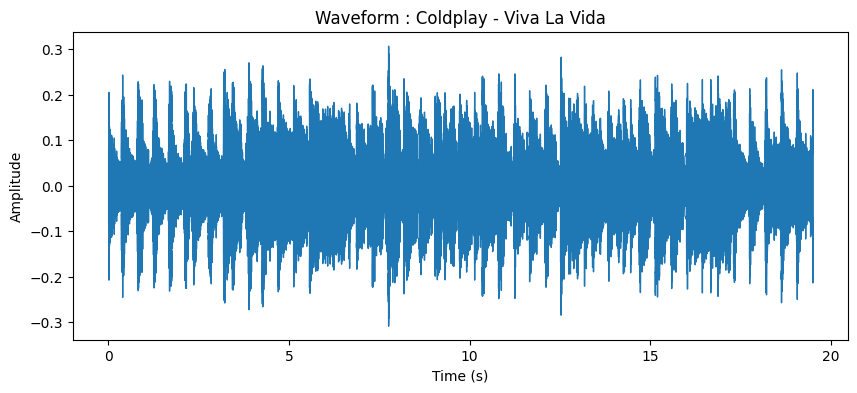

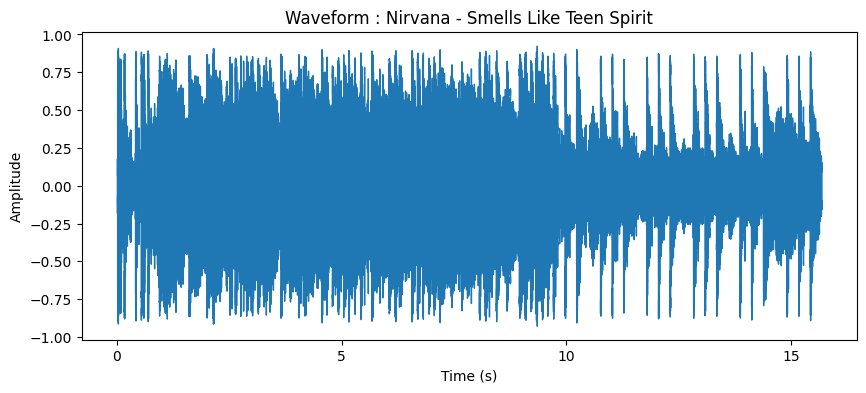

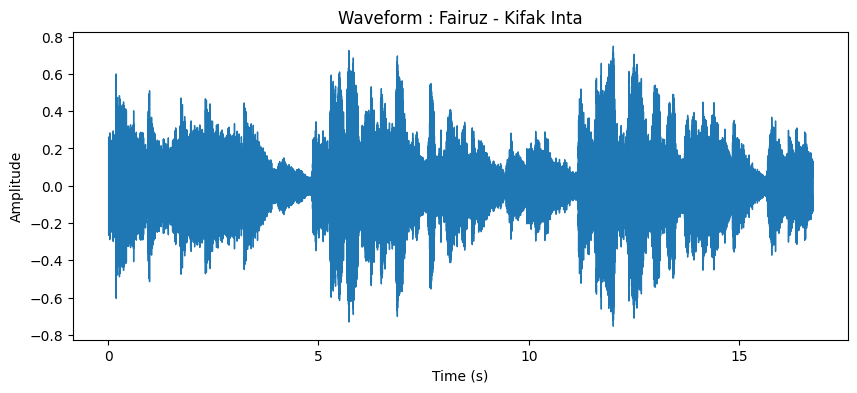

In [ ]:
# Loading and Displaying Waveforms For Each Song
for data in audio_files:
    path = data['file_path']
    title = data['title']
    y, sr = librosa.load(path, sr=None)
    file_name = os.path.basename(path)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform : {title}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

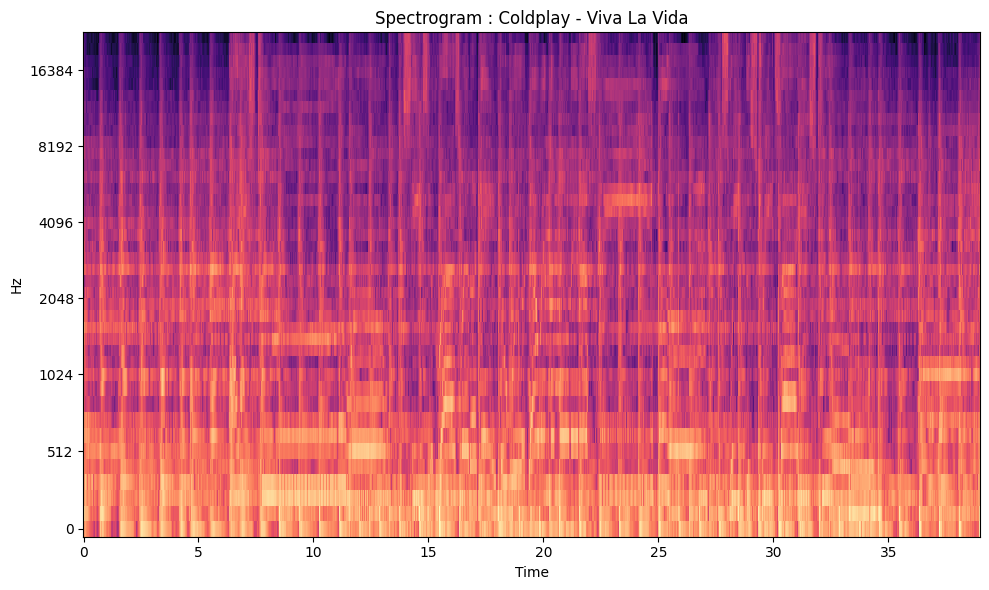

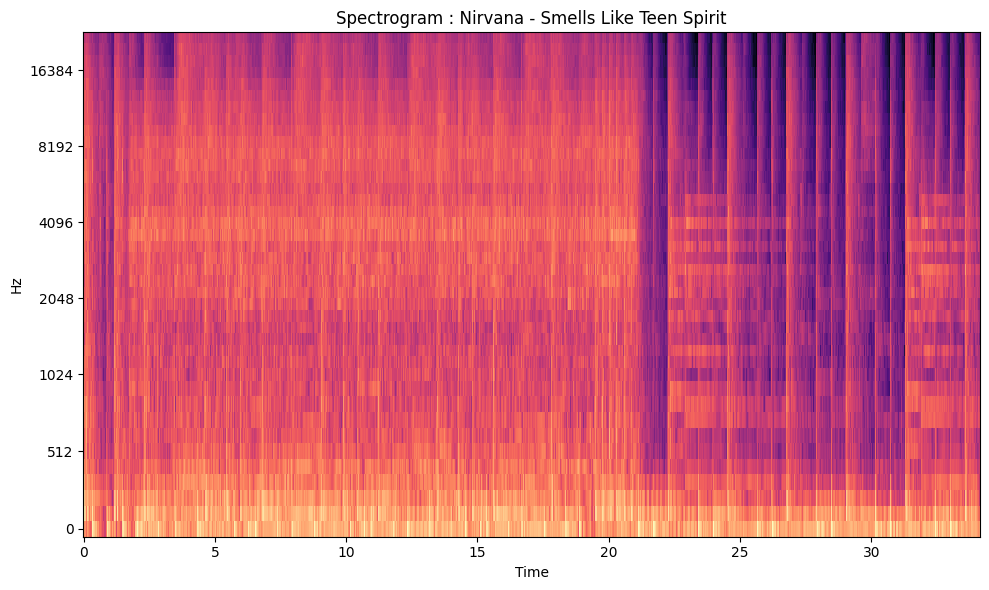

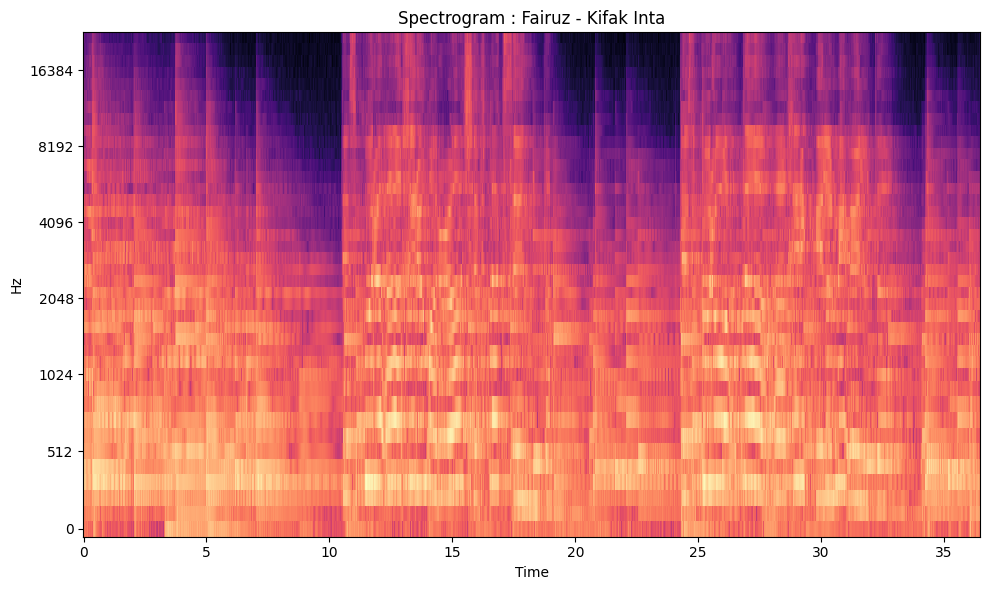

In [ ]:
X_train = []
y_train = []

max_time_frames = 0

# Loading and Displaying Spectograms For Each Song
for data in audio_files:
  path = data['file_path']
  title = data['title']

  n_fft = 1024
  hop_length = 256
  n_mels = 40
  f_min = 20
  f_max = 8000
  y, sr = librosa.load(path, sr=None)
  file_name = os.path.basename(path)
  Melspectrogram = librosa.feature.melspectrogram(y=y, sr=44100, n_fft=n_fft, hop_length=hop_length,
                                n_mels=n_mels, power=1.0, fmin=f_min, fmax=f_max)
  Melspectrogram_db = librosa.power_to_db(Melspectrogram, ref=np.max)
  plt.figure(figsize=(10, 6))
  librosa.display.specshow(Melspectrogram_db, sr=44100, x_axis='time', y_axis='mel')
  plt.title(f'Spectrogram : {title}')
  plt.tight_layout()
  #plt.show()


  max_time_frames = max(max_time_frames, Melspectrogram_db.shape[1])

  #Preparing Training Data
  X_train.append(Melspectrogram_db)
  y_train.append(title)

In [ ]:
#Convert Labels to Numerics
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

#Resizing features
X_train_padded = []

for spectrogram in X_train:
    pad_width = max_time_frames - spectrogram.shape[1]
    padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    X_train_padded.append(padded_spectrogram)

# Reshaping features for the Conv2D layer
X_train_padded = np.array(X_train_padded)[:, :, :, np.newaxis]

# Define the Model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(n_mels, max_time_frames, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Compile the Model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training
model.fit(X_train_padded, y_train_encoded, epochs=10, batch_size=32)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 1.1916 - accuracy: 0.6667
Epoch 2/10
1/1 [==============================] - 0s 472ms/step - loss: 1068.4039 - accuracy: 0.3333
Epoch 3/10
1/1 [==============================] - 0s 441ms/step - loss: 586.5724 - accuracy: 0.3333
Epoch 4/10
1/1 [==============================] - 0s 478ms/step - loss: 158.8187 - accuracy: 0.3333
Epoch 5/10
1/1 [==============================] - 0s 471ms/step - loss: 13.4048 - accuracy: 0.6667
Epoch 6/10
1/1 [==============================] - 1s 512ms/step - loss: 46.2563 - accuracy: 0.6667
Epoch 7/10
1/1 [==============================] - 1s 710ms/step - loss: 23.7599 - accuracy: 0.6667
Epoch 8/10
1/1 [==============================] - 1s 582ms/step - loss: 0.0152 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 480ms/step - loss: 93.4112 - accuracy: 0.3333
Epoch 10/10
1/1 [==============================] - 0s 458ms/step - loss: 13.0224 - accuracy: 0.6667


In [ ]:
def predict_song_title(song_path, model, label_encoder):
    # Load and process the audio file
    y, sr = librosa.load(song_path, sr=None)
    Melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
                                                   n_mels=n_mels, power=1.0, fmin=f_min, fmax=f_max)
    Melspectrogram_db = librosa.power_to_db(Melspectrogram, ref=np.max)


    pad_width = max_time_frames - Melspectrogram_db.shape[1]
    input_spectrogram = np.pad(Melspectrogram_db, ((0, 0), (0, pad_width)), mode='constant')
    input_spectrogram = input_spectrogram[:, :, np.newaxis]

    #Get predictions
    prediction = model.predict(np.expand_dims(input_spectrogram, axis=0))
    predicted_index = np.argmax(prediction)
    predicted_title = label_encoder.classes_[predicted_index]

    return predicted_title

#TEST
song_path_to_predict='/content/Nirvana - Smells Like Teen Spirit.wav'
#song_path_to_predict='/content/Coldplay - Viva La Vida.wav'
#song_path_to_predict='/content/Fairuz - Kifak Inta.wav'

predicted_title = predict_song_title(song_path_to_predict, model, label_encoder)
print(f"Predicted Song Title: {predicted_title}")

1/1 [==============================] - 0s 47ms/step
Predicted Song Title: Nirvana - Smells Like Teen Spirit
